## Code for determining bound / unbound frames & apparent equilibrium constants from CG simulations
This script takes input files from a pre-processing step that performs a periodic boundary condition correction (in-house tool, 'lammpstools_pbc_fix') and converts coarse-grained trajectories into 'center-of-mass' (COM) trajectories (in-house tool, 'lammpstools_build_comtraj'). The resulting trajectory contains one bead per chain (called 'CM') located at the center of mass position of the original chain.

This code generates sample versions of Figures S4A and B.

#### For each simulation:
1. loads in COM traj and pdb files for each replicate
2. calculates the per frame COM-COM distance (intermolecular distance as measured from center-of-mass)
3. fits the population of distances to two gaussians (one for each bound and unbound population)
4. from these distributions, determines a distance cutoff (53.5 A for my SERF-RNA sims)
5. writes out a .txt file containing B22-corrected Kd calculations for all replicates
6. generates the following two plots: (1) 2-gaussian distribution w/ fits AND (2) plot of COM distances by frame for QC

Save this script in the parent directory that houses the numbered replicate simulation files. Each replicate file must contain COM trajectory and topology files. User must also create a directory called 'ana_batch' that will be populated by this script. Your directory structure should look something like:

- serf-u30/
    - 1/
    - 2/
    - 3/
    - 4/
    - 5/
        - comtraj.pdb
        - comtraj.xtc
    - ana_batch/
    - cg_simulation_processing.ipynb


This data processing workflow was adapted from Alston et al 2023 (DOI: 10.1101/2023.08.06.552128).

In [1]:
## import packages ##
from soursop.sstrajectory import SSTrajectory
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
import seaborn as sns
import scipy
import mdtraj as md
import argparse
import pandas as pd
import itertools

## User inputs here:

In [3]:
# enter simulation name
sim_name = 'serf-u30'

# number of replicates
replicates = 5

# provide box side length in nm 
L = 40

# set rdf bin width
bin_width = 0.2

# this defines the number of contiguous frames below the bound cutoff we need to say a chain is in the bound state
bound_length = 5

# this is a single conversion factor that converts simulation Kd and Ka to experimental values, should those be known
sim2exp_factor = 0.1

# molecular weight of SERF protein (g/mol)
MW_PROT = 7950

# conversion factor for Kd units
M2uM = 1e6

# molecular weight of RNA molecule
MW_RNA = 8820    # https://www.aatbio.com/tools/calculate-RNA-molecular-weight-mw


## Functions here:

In [4]:
def correctRDF(r, rdf, L):
    """
    Implementation of corrected radial distribution
    function as taken directly from Ganguly and van der Vegt [1],
    using the impmentation by Tesei et al.[2].
    
    This requires that the distance bins (r) be in the same units
    as the box length (L). Typically both will be in nanometers.
    
    Recall the radial distrubution function (g(r)) rorts on the
    density of molecules at some distance from the center as a ratio
    of the actual density/expected density in bulk - i.e. this is a 
    unitless value (ratio of 2 densities).
    
    As an side, this also means the Meyer integral of the radial 
    distribution function returns the B22 in units of distance used 
    cubed (i.e. volume).        
        
    Parameters
    -------------
    r : np.ndarray
        Array of bin positions for the radial distribution function
        (rdf).
        
    rdf : np.ndarray
        Counts associated with the corresponding bins for the RDF. 
        
    L : float
        Box dimensions (in nanometers)
        
    Returns
    ------------
    np.array
        Corrected counts associated with the corresponding bins for 
        the RDF
    
    Reference
    --------------
    [1] Ganguly, P., & van der Vegt, N. F. A. (2013). Convergence of Sampling 
        Kirkwood-Buff Integrals of Aqueous Solutions with Molecular Dynamics 
        Simulations. Journal of Chemical Theory and Computation, 9(3), 1347–1355.
        
    [2] Tesei, G., Schulze, T. K., Crehuet, R., & Lindorff-Larsen, K. (2021). 
        Accurate model of liquid–liquid phase behavior of intrinsically disordered 
        proteins from optimization of single-chain properties. Proceedings of the 
        National Academy of Sciences of the United States of America, 118(44). 
        https://doi.org/10.1073/pnas.2111696118
    """
    
    # get bin width
    dr = r[1]-r[0]
    
    # volume of box in nm cubed
    V = L**3
    
    Nouter = 1 - 4/3*np.pi*r**3 / V
    
    DeltaN = 1/V*4*np.pi*dr*np.cumsum( (rdf - 1 ) * r**2)
    
    return rdf * Nouter / ( Nouter  - DeltaN)

In [5]:
def naive_Kd(p_bound, L):
    """
    Calculate the binding affinity using the so-called niave 
    assumption from Jost et al. [1]
        
    Parameters
    --------------
    p_bound : float
        Fraction of the simulation in which the two molecules 
        are bound. How one defines 'bound' is often the hard 
        question. This is unitless (i.e. is a fraction)
        
    L : float
        Box dimensions (in nanometers)
        
    Returns
    -------------
    float
    
        Returns the kD in molar units (mol/L)
        
    Reference
    --------------
    [1] - Jost Lopez, A., Quoika, P. K., Linke, M., Hummer, G., 
    & Köfinger, J. (2020). Quantifying Protein–Protein Interactions 
    in Molecular Simulations. The Journal of Physical Chemistry. B, 
    124(23), 4673–4685.

    """
    
    # Avogadro's number - recall that 1/NA gives us units of mol
    # because NA/NA = 1 mol 
    N_A = 6.02214076*1e23
    
    # Volume of simulation box in L (convert to cubic meters and)
    # then to liters
    V = 1e3*((L*1e-09)**3)
    
    # kd (in mol/L) determined from p_bound
    kd = ((1-p_bound)**2) / (N_A*V*p_bound)
    print(p_bound)
    
    return kd

In [6]:
def kd_from_b22(b22, p_bound, L, MW_A, MW_B):
    """
    Calculate the dissociation constant using B22 as a correction
    factor to account for intrinsic non-specific binding, as defined
    in Jost et al. [1].
    
    Parameters
    --------------
    b22 : float
        Second virial coefficient, in units of l mol / g^2 [that's
        liters mols per gram squared].
        
    p_bound : float
        Fraction of the simulation that the molecules are bound, this
        is unitless
        
    L : float
        Box dimensions (in nm)
        
    MW_A : float
        Molecular weight of reference molecule (in g/mol)

    MW_B : float
        Molecular weight of query molecule (in g/mol)

    Returns
    ------------
    float
        Returns the B22-corrected Kd in M
        
    Reference
    -----------
    [1] - Jost Lopez, A., Quoika, P. K., Linke, M., Hummer, G., 
    & Köfinger, J. (2020). Quantifying Protein–Protein Interactions 
    in Molecular Simulations. The Journal of Physical Chemistry. B, 
    124(23), 4673–4685.
    """
    
    # Avogadro's number in units 1/mol
    N_A = 6.02214076*1e23
    
    # Volume of simulation box in L
    V = ((L*1e-09)**3)*1000
    
    # conversion factor for b22 (from µl mol / g2 to L) 
    # recall MW_A *MW_B = g^2/mol^2 * 1/N_A = g^2/mol^1
    
    convert_units = (MW_A * MW_B)*1e-6/N_A
    
    # return Jost equation in the right unit - 1/Na * 1/vol
    # 1/Na = mol units and 1/vol - l^{-1} units, so 
    # final units are mol/l (or M)
    return 1/(N_A*p_bound*(V-2*b22*convert_units))

In [14]:
def calcB22(r, rdf, MW_A, MW_B):
    """
    Returns second virial coefficient in 
    microliters * mol / grams squared
    
    Parameters
    ------------------
    r : np.ndarray
        Array of bin positions for the radial distribution function
        (rdf).
        
    rdf : np.ndarray
        Counts associated with the corresponding bins for the RDF.

    MW_A : float
        Molecular weight of molecule 1
        
    MW_B : float
        Molecular weight of molecule 2
        

    Returns
    -----------
    float
        Returns a Kd in µl mol / g2
    """
    
    # meyer F-integral - NOTE the negative sign here is needed
    # the inner integral is rdf - 1 instead of 1 - rdf
    B22 = -2*np.pi*np.trapz((rdf-1)*r*r,r)
    
    # note - this here is the original conversion equation implemented by
    # tesei et al
    #return B22 * 6.022e23 / 1e21 / MW**2 * 1e3 # µl mol / g2
    
    #  Below is the same numerical calculation just written
    # differently to make it a bit clearer what the conversion factors
    # are doing
    return B22 * 6.022e23 * (1/1e27) * 1e3 * 1e6 * (1/ (MW_A*MW_B))  # µl mol / g2

In [15]:
def build_traces(COM_distance, bound_length, cutoff):
    """
    Function that assesses bound and unbound states based on contigous stretches of
    the simulation where the centers of mass are conistently below some threshold.
    
    In particular, $bound_length defines the number of consecutive frames which must 
    be below some threshold for a simulation to be considered bound. $cutoff defines what
    this distance threshold is. For example, if bound_length=20 (default) we only consider
    regions of the inter-molecular COM distance. 
    
    Parameters
    -------------
    COM_distances : np.ndarray
        Array of inter-molecular center of mass (COM) distances. Expect one value
        per frame.
        
    bound_length : int
        Number of consecutive frames required to designate an interaction as 'bound'
        
    cutoff : float
        Distance (in Angstroms) used to define if two molecules are bound or not. Note
        this is the COM distance, not the minimum contact distance (!).
        
        
    Returns
    -----------
    tuple
        Returns a tuple with three elements
        
        # fraction bound
        [0] - float      - the fraction bound of this simulation
        
        # bound_trace
        [1] - np.ndarray - shape=(2,n), where the two columns are the
                           index of a bound frame and the distance in 
                           that frame
                           
        # unbound_trace
        [2] - np.ndarray - shape=(2,n), where the two columns are the
                           index of a bound frame and the distance in 
                           that frame
    
    """

    # initialize some variables
    bound_trace = []
    unbound_trace = []
    inside = False

    all_bound_idx = set()
    all_unbound_idx = set()

    idx = bound_length-1
    
    # cycle over the bound_length-thed index to the end of
    # the COM array
    for idx in range(bound_length, len(COM_distance)):

        # get the distance at the idx position
        i = COM_distance[idx]

        # define the preceding bound_length-sized set of
        # frames (i.e. the 'history' is the set frames
        # that come $bound_length before the current 
        # index
        history = COM_distance[idx-bound_length:idx]

        # if we're already 'inside' a bound part of the
        # trajectory
        if inside:  
            
            # if under the cutoff then carry on, we've found
            # additional frames in a contigous set of frames 
            # that are bound
            if i < cutoff:            
                bound_trace.append([idx,i])
                all_bound_idx.add(idx)
                
            # if we're above the cutoff then this means an unbinding
            # event happens
            else:
                inside = False
                
        # if we're not currently inside a bound set of frames
        else:
            
            # if this frame is bound
            if i < cutoff:
                
                # if were the last set of frames all under the reshold
                if np.max(history) < cutoff:
                    
                    # if yes we're insidew
                    inside = True

                    for tmp_idx, tmp_i in enumerate(history):
                        local_idx = idx-(bound_length - tmp_idx)
                        bound_trace.append([local_idx, tmp_i])
                        all_bound_idx.add(local_idx)
                        
                    bound_trace.append([idx,i])
                    all_bound_idx.add(idx)


    # now, having classufued every frame, we can go through all the frames and 
    # if they're not in one of the all_bound_idx set they must be all unbound
    for idx in range(bound_length, len(COM_distance)):
        i = COM_distance[idx]
        if idx not in all_bound_idx:
            unbound_trace.append([idx,i])
            all_unbound_idx.add(idx)
        
    bound_trace = np.array(bound_trace).transpose()
    unbound_trace = np.array(unbound_trace).transpose()
    
    # calculate the fraction bound
    fraction_bound = len(all_bound_idx)/(len(all_unbound_idx)+len(all_bound_idx))
 
    return (fraction_bound, bound_trace, unbound_trace)

In [16]:
def build_rdfs(cmtraj, L, bin_width=0.2):
    """
    Function that calculates the radial distribution function (g(r)) for our 
    center of mass trajectories. Specifically, this function expects `cmtraj`
    to be passed as an mdtraj.traj object where there are an arbitrarily large
    number of frames but there must ONLY be 2 chains where each chain has a 
    single residue - i.e. a center-of-mass trajectory
    
    Note that by default this implementation calculates the RDF between r=0 and
    r=L/2. This is important because if you make the upper limit of this integral
    big it causes some isues
    
    Parameters
    ---------------
    mdtraj.traj
        MDTraj trajectory object for a center-of-mass (COM) trajectory, i.e. a 
        trajectory with only 
        
    L : float
        Box size (in nanometers)
        
    
    bin_width : float
        Width of RDF bins in nanometers (recommend 0.2)
        
    Returns
    ----------
    
    """

    # half box size - for PBC corrected sims this is always correct
    max_integral = L/2
    
    rdf = md.compute_rdf(cmtraj, [[0,1]], r_range=(0,max_integral), bin_width = bin_width, periodic=True)
    
    rdf_c = correctRDF(rdf[0],rdf[1], L)
    
    return (rdf[0], rdf_c, rdf[1])

## Back-end stuff:

In [17]:
# takes user-inputted number of replicates and makes a list of reps 1 thru n
Replicates = [*range(1, replicates+1, 1)]

# predefine lists for loop in the next cell
All_dists = []
flat_list = []

# Here we want to make it easy to plot individual simulations and there replicates fast so we store each 
# simulation type as its own list of values corresponding to the desired calculation

Kd_naive = []
Ka_naive = []

Kd_B22 = []
Ka_B22 = []
B22s = []

Kd_naive_std = []
Ka_naive_std = []

Kd_B22_std = []
B22s_std = []
Ka_B22_std = []

fraction_bound = {}
len2COM_distance = {}
len2COM_rdfs = {}
len2COM_bound_trace = {}
len2COM_unbound_trace = {}

## the fun stuff:

In [18]:
for rep in Replicates:
    
    # read in the COM traj & pdb files that are inside each replicate folder 
    traj = SSTrajectory(str(rep)+ '/comtraj.xtc', str(rep)+ '/comtraj.pdb', extra_valid_residue_names = ['CM'])
    
    # use soursop to calculate COM distance (this is easy because 'lammpstools_build_comtraj' script turns each molecule into a single CG residue lol)
    # returns distance in Angstroms
    COM_distance = traj.get_interchain_distance(0,1,0,0)
    
    len2COM_distance[rep] = COM_distance
    
for i in Replicates:
    
    flat_list.append(len2COM_distance[i])

All_distance = [item for sublist in flat_list for item in sublist]

In [19]:
# make bins for the COM distances
top_bin = int(round(max(All_distance), 0))
hist, bins = np.histogram(All_distance, bins = [j for j in range(0, top_bin+1, 1)])

# this is straight outta J's code
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

bins_average = moving_average(bins, 2)

## define Gaussians for fitting ##
def _1gaussian(x, amp1, cen1, sigma1):
    return amp1 * (1 / (sigma1 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((bins_average - cen1) / sigma1) ** 2)))

def _2gaussian(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
    gauss1 = amp1 * (1 / (sigma1 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((bins_average - cen1) / sigma1) ** 2)))
    gauss2 = amp2 * (1 / (sigma2 * (np.sqrt(2 * np.pi)))) * (np.exp((-1.0 / 2.0) * (((bins_average - cen2) / sigma2) ** 2)))
    return gauss1 + gauss2

In [20]:
## FITTING CELL ##

# set initial guesses #
amp1 = 5000
cen1 = 20     # center-ish of bound pop peak
sigma1 = 5

amp2 = 2000
cen2 = 150   # center-ish of unbound pop peak
sigma2 = 15

# FIT #
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, bins_average, hist, p0 = [amp1, cen1, sigma1, amp2, cen2, sigma2], maxfev = 5000)
err_2gauss = np.sqrt(np.diag(pcov_2gauss))

params1 = popt_2gauss[0:3]
params2 = popt_2gauss[3:6]

# individual peak fits based on start parameters #
gauss_peak1 = _1gaussian(bins_average, *params1)
gauss_peak2 = _1gaussian(bins_average, *params2)

# calculate residuals of 2gaussian fit #
residuals_2gauss = hist - (_2gaussian(bins_average, *popt_2gauss))

# get indices of each peak max. #
peak1_idx = np.argmax(gauss_peak1)
peak2_idx = np.argmax(gauss_peak2)

peaks = [peak1_idx, peak2_idx]
sorted_peaks = sorted(peaks)

summed_list = gauss_peak1[sorted_peaks[0]:sorted_peaks[1]] + gauss_peak2[sorted_peaks[0]:sorted_peaks[1]]
min_idx = summed_list.argmin()

#threshold = bins_average[sorted_peaks[0]:sorted_peaks[1]][min_idx]

# threshold value (Angstroms) set to 53.5 for all SERF-RNA simulations
threshold = 53.5

In [21]:
## do the Kd calculation for all replicates

for repp in Replicates:
    # calculate the fraction bound
    tmp = build_traces(len2COM_distance[repp], cutoff=threshold, bound_length=bound_length)
    fraction_bound = tmp[0]
    len2COM_bound_trace[repp] = tmp[1]
    len2COM_unbound_trace[repp] = tmp[2]

    # now construct radial distribution function using the naive & Ganguly-corrected methods
    traj = SSTrajectory(str(repp)+ '/comtraj.xtc', str(repp)+ '/comtraj.pdb', extra_valid_residue_names = ['CM'])
    (r, real_rdf, simple_rdf) = build_rdfs(traj.traj, L, bin_width=bin_width)

    #len2COM_rdfs[repp] = [r, real_rdf, simple_rdf]
    
    ## calculate second virial coefficient (B22) ##
    b22 = calcB22(r, real_rdf, MW_PROT, MW_RNA)
    
    ## calculate Kd using B22 correction ##
    kDB_temp = kd_from_b22(b22, fraction_bound, L, MW_RNA, MW_PROT)
    #print(kDB_temp)
    
    ## calculate naive Kd ##
    kDn_temp = naive_Kd(fraction_bound, L)
    #print(kDn_temp)
    
    Kd_naive.append(kDn_temp)
    Kd_B22.append(kDB_temp)
    B22s.append(b22)

# writes out the list of apparent dissociation constants for each replicate (in M)
np.savetxt('ana_batch/' +str(sim_name)+ '_repKds.txt', Kd_B22)

## now compute the averages & stddev across replicates ##
Kd_naive_avg = np.mean(sim2exp_factor*np.array(Kd_naive)*M2uM)
Kd_naive_std = np.std(sim2exp_factor*np.array(Kd_naive)*M2uM)

Kd_B22_avg = np.mean(sim2exp_factor*np.array(Kd_B22)*M2uM)
Kd_B22_std = np.std(sim2exp_factor*np.array(Kd_B22)*M2uM)


0.5145392559911762
0.4310137370901434
0.42108693472375414
0.41396771282462647
0.4702697282663191


In [23]:
## determine the indices for bound vs. unbound frames based on the inter-COM distance threshold;
## writes out to text files: 'bound_frame_list.txt' and 'unbound_frame_list.txt'

frames = range(1, len(All_distance)+1)

bound_frames = []
unbound_frames = []
for i in range(0, len(All_distance)-1):
    if All_distance[i] >= 53.5:
        unbound_frames.append(int(frames[i]))
    else:
        bound_frames.append(int(frames[i]))
        
np.savetxt('ana_batch/bound_frame_list.txt', bound_frames)
np.savetxt('ana_batch/unbound_frame_list.txt', unbound_frames)

## plotting & figures:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Avenir, AvenirNextLTPro, "Avenir Next LT Pro", Univers, UniversLTStd, AvenirNextLTPro-Regular, UniversLTStd-Light, Verdana, Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Avenir, AvenirNextLTPro, "Avenir Next LT Pro", Univers, UniversLTStd, AvenirNextLTPro-Regular, UniversLTStd-Light, Verdana, Helvetica


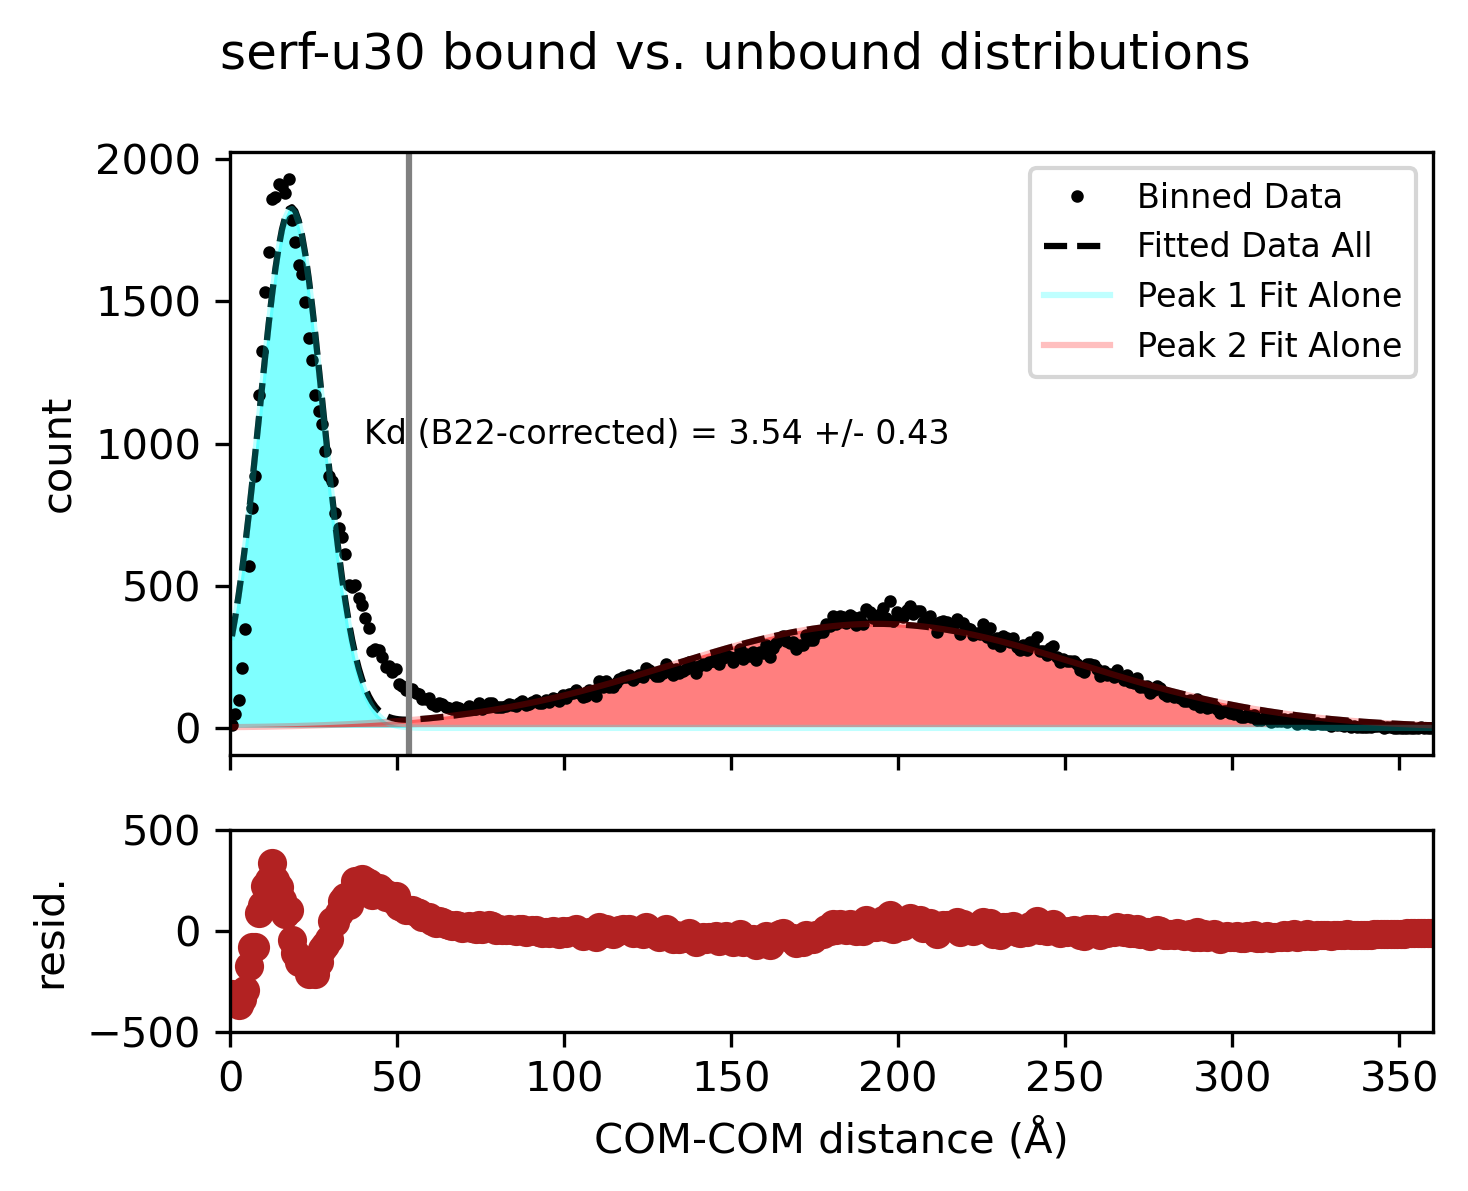

In [24]:
## plot unbound and bound distributions -- generates Figure S4B ##

f, (a0, a1) = plt.subplots(2, 1, figsize = (5,4), sharex = True, dpi = 300, gridspec_kw={'height_ratios': [3, 1]})

# data & fit suplot
a0.plot(bins_average, hist, "ko", markersize = 2)
a0.plot(bins_average, _2gaussian(bins_average, *popt_2gauss), 'k--')

# peak 1
a0.plot(bins_average, gauss_peak1, "cyan", alpha = 0.25)

# peak 2
a0.plot(bins_average, gauss_peak2, "red", alpha = 0.25)

a0.fill_between(bins_average, gauss_peak1.min(), gauss_peak1, facecolor="cyan", alpha=0.5)
a0.fill_between(bins_average, gauss_peak2.min(), gauss_peak2, facecolor="red", alpha=0.5)  

a0.axvline(threshold, color='grey')

# residuals subplot
a1.scatter(bins_average, residuals_2gauss, color = 'firebrick')
a1.set_ylabel('resid.')
a0.set_ylabel('count')

a0.annotate('Kd (B22-corrected) = ' +str(np.round(Kd_B22_avg,2))+ ' +/- ' +str(np.round(Kd_B22_std,2)), xy = (40, 1000), fontsize = 8)

f.suptitle(str(sim_name)+ ' bound vs. unbound distributions')

plt.xlabel('COM-COM distance (Å)')

plt.xlim(-0, 360)
a0.legend(['Binned Data','Fitted Data All','Peak 1 Fit Alone', 'Peak 2 Fit Alone'], loc='upper right', prop={'size':8})
a1.set_ylim(-500, 500)

f.tight_layout()

f.savefig('ana_batch/' +str(sim_name)+ '_COM_dists_FIT.png', format = 'png', dpi = 300)

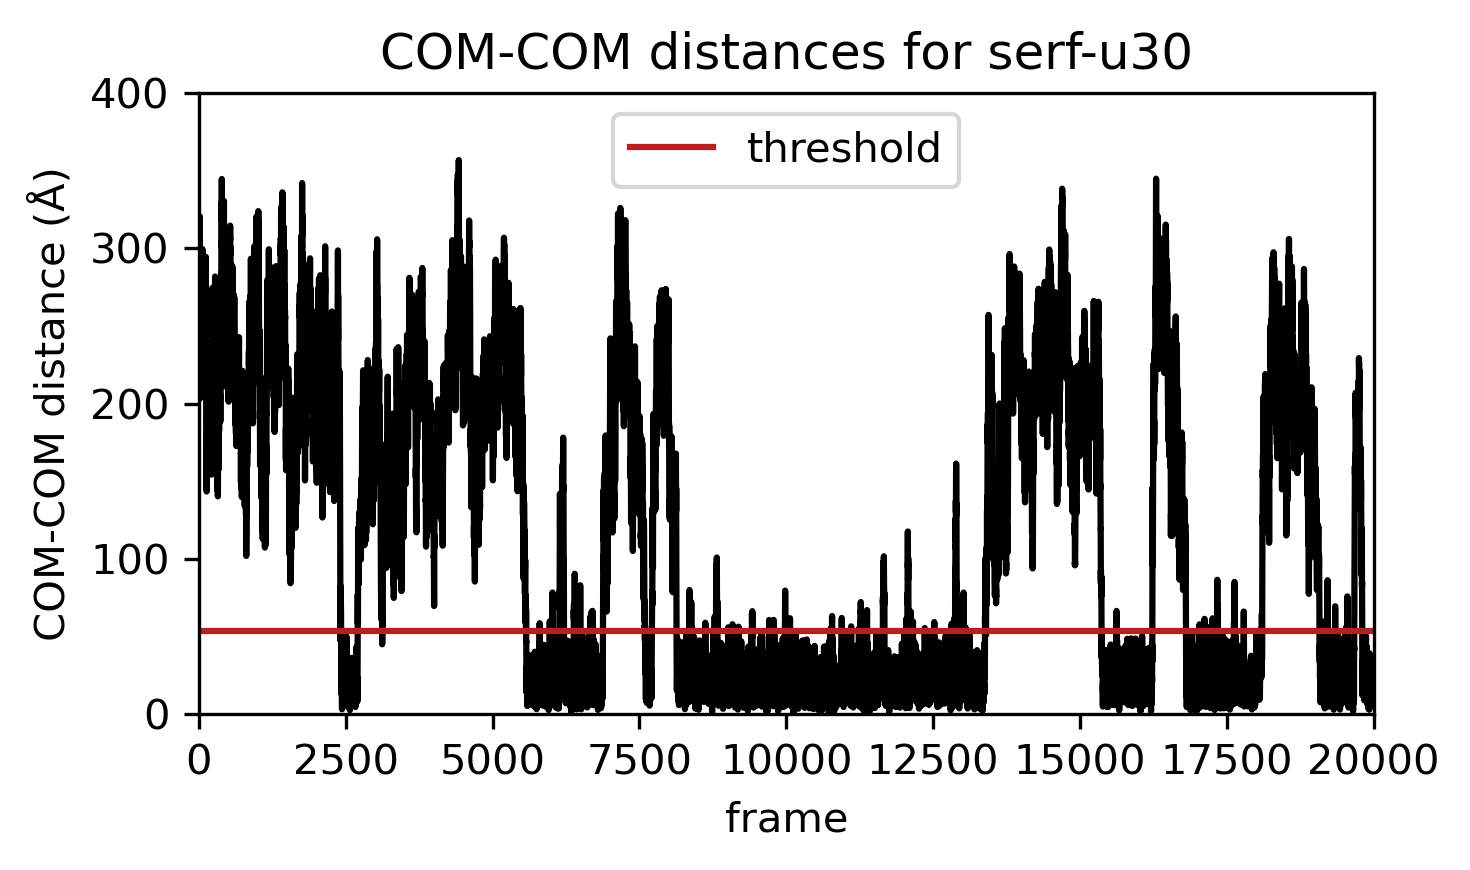

In [25]:
## plot COM distance vs. simulation frame -- generates Figure S4A ##
plt.figure(figsize = (5,3), dpi = 300)

plt.plot(COM_distance, color = 'k')
plt.axhline(y = threshold, color = 'firebrick', label = 'threshold')

plt.title('COM-COM distances for ' +str(sim_name))
plt.ylabel('COM-COM distance (Å)')
plt.xlabel('frame')
plt.xlim([0, 20000])
plt.ylim([0, 400])

plt.legend()

plt.tight_layout()
plt.savefig('ana_batch/com-com_' +str(sim_name)+ '.png', format = 'png', dpi = 300)